In [9]:
import cv2 as cv
import mrob
import numpy as np
import open3d as o3d
import os
import pickle

In [10]:
def pointcloudify_depth(depth, intrinsics, dist_coeff, undistort=True):
    shape = depth.shape[::-1]
    
    if undistort:
        undist_intrinsics, _ = cv.getOptimalNewCameraMatrix(intrinsics, dist_coeff, shape, 1, shape)
        inv_undist_intrinsics = np.linalg.inv(undist_intrinsics)

    else:
        inv_undist_intrinsics = np.linalg.inv(intrinsics)

    if undistort:
        # undist_depthi = cv.undistort(depthi, intrinsics, dist_coeff, None, undist_intrinsics)
        map_x, map_y = cv.initUndistortRectifyMap(intrinsics, dist_coeff, None
                                                  , undist_intrinsics, shape, cv.CV_32FC1)
        undist_depth = cv.remap(depth, map_x, map_y, cv.INTER_NEAREST)

    # Generate x,y grid for H x W image
    grid_x, grid_y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    grid = np.concatenate([np.expand_dims(grid_x, -1),
                           np.expand_dims(grid_y, -1)], axis=-1)

    grid = np.concatenate([grid, np.ones((shape[1], shape[0], 1))], axis=-1)

    # To normalized image coordinates
    local_grid = inv_undist_intrinsics @ grid.reshape(-1, 3).transpose()  # 3 x H * W

    # Raise by undistorted depth value from image plane to local camera space
    if undistort:
        local_grid = local_grid.transpose() * np.expand_dims(undist_depth.reshape(-1), axis=-1)

    else:
        local_grid = local_grid.transpose() * np.expand_dims(depth.reshape(-1), axis=-1)
        
    return local_grid.astype(np.float32)

In [12]:
filepath = 'CameraTrajectory.txt'
poses_quat = []
with open(filepath, 'r') as file:
    for line in file:
        poses_quat.append([float(i) for i in line.split(' ')])

In [13]:
azure_depth_folder = '../2021-04-14-15-17-49/_azure_depth_image_raw/'

depth_ts = np.array([int(file.split('.')[0]) for file in os.listdir(azure_depth_folder) 
                     if file.endswith('.npy')])
depth_ts.sort()
depth_ts

array([503831991962, 504031853466, 504231981466, 504431934874,
       504631829402, 504831916186, 505031915418, 505231885466,
       505431893402, 505631855002, 505831751066, 506031824282,
       506231827866, 506431667354, 506631781530, 506831734426,
       507031597210, 507231674778, 507431658394, 507631632794,
       507831613850, 508031480218, 508231578010, 508431528602,
       508631512474, 508831480218, 509031469978, 509231429274,
       509431307418, 509631388570, 509831380122, 510031349146,
       510231341722, 510431299738, 510631282842, 510831231386,
       511031215770, 511231158426, 511431155610, 511631123098,
       511831113882, 512030950554, 512231056538, 512431005850,
       512630993306, 512830846106, 513030942106, 513230895258,
       513430889626, 513630734746, 513830830490, 514030684570,
       514230787482, 514430732186, 514630705306, 514830568602,
       515030655130, 515230601114, 515430476442, 515630549914,
       515830537370, 516030379418, 516230481818, 516430

In [14]:
SETUP_CONFIG = 'bandeja_standard.pickle'
with open(SETUP_CONFIG, 'rb') as config:
    config_dict = pickle.load(config)

In [15]:
import numpy as np
import colorsys

def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

In [18]:
N = 20

colors = get_colors(len(poses_quat) // N + 1)
geometries = []
Ts = []
part = 150

for i, pose in enumerate(poses_quat[0:part]): 
    t = pose[1:4]
    R = mrob.geometry.quat_to_so3(pose[4:8])
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    Ts.append(T)
    if not i % N:
        coord = o3d.geometry.TriangleMesh.create_coordinate_frame(0.1).transform(T)
        c = i / (part + 1)
        coord.paint_uniform_color([0.5,1 - c, (1 - c) / 2])
        geometries.append(coord)


T = np.load('azure2s10_standard_extrinsics(1).npy')
full_pcd = None
for i, ts in enumerate(depth_ts[0:part]):
    if not i % N:
        depth = np.load(os.path.join(azure_depth_folder, str(ts) + '.npy'))
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pointcloudify_depth(depth, config_dict['depth']['dist_mtx'],
                                                config_dict['depth']['dist_coef']))
        pc = pcd.transform(T).transform(Ts[i])
#         pc.paint_uniform_color(colors[i // N])
        c = i / (part + 1)
        pc.paint_uniform_color([0.5,1 - c, (1 - c)/ 2])
        if full_pcd == None:
            full_pcd = pc
        else:
            full_pcd += pc

downpcd = full_pcd.voxel_down_sample(voxel_size=0.005)
geometries.append(downpcd)

o3d.visualization.draw_geometries(geometries)

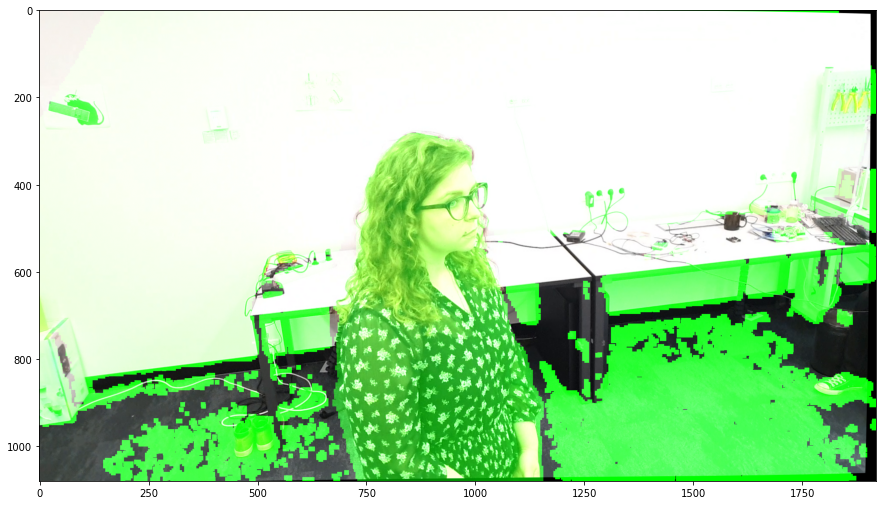

In [8]:
import matplotlib.pyplot as plt
depth = cv.imread('2021-04-14-15-17-49/depth/530.028562586.png')
rgb = cv.imread('2021-04-14-15-17-49/rgb/530.024231777.png')


gray = cv.cvtColor(depth, cv.COLOR_BGR2GRAY)
rgb = cv.cvtColor(rgb, cv.COLOR_BGR2RGB)
depth_r = np.stack((np.zeros(gray.shape), gray,  np.zeros(gray.shape)), axis=2)
plt.figure(figsize=(15, 9))
plt.imshow(np.clip(depth_r / 50 + rgb / 255, 0, 1))
# plt.imshow(rgb)